In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import e
from math import log
import scipy.io as sc
from scipy.special import expit, logit
%matplotlib inline

In [2]:
def logistic_fn(x,w):
    
    return expit(np.dot(x,w))

In [3]:
def update(x,w,y,s_vals):
    hess_inv = np.linalg.inv(np.matmul(np.matmul(x.T,np.diag(s)),x))
    diff = np.matmul(x.T,(y - s))
    return w - np.matmul(hess_inv,diff)

### Problem 2.4 (do not submit)

In [100]:
x = np.array([[0.2, 3.1, 1],
             [1.0, 3.0, 1],
             [-0.2, 1.2, 1],
             [1.0, 1.1, 1]])

In [101]:
y = np.array([1,1,0,0])

In [108]:
w0 = [-1, 1, 0]

In [109]:
s0=[]
for i in range(x.shape[0]):
    s0+=[s(x[i],w0)]

In [119]:
s0 = logistic_fn(x,w0)

In [120]:
s0

array([0.94784644, 0.88079708, 0.80218389, 0.52497919])

In [111]:
w1 = update(x,w0,y,s0)

In [112]:
w1

array([-1.09534796,  0.43773381,  1.67830773])

In [113]:
s1 = logistic_fn(x,w1)

In [118]:
s1

array([0.94354568, 0.86945643, 0.91853884, 0.74354326])

# Q3.2

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [338]:
#returns the mean and stdev of the features of the input data as a list of tuples

def get_fit(data):
    
    stats = []
    
    for i in range(data.shape[1]):
        
        stats+=[(data[:,i].mean(), data[:,i].std())]
        
    return stats


In [339]:
#normalizes the features of a dataset by subtracting the training mean and dividing by the training stdev; the stats variable
#should be a list of tuples

def transform(data,stats):
    
    for i in range(data.shape[1]):
        
        data[:,i] = (data[:,i]-stats[i][0])/stats[i][1]
    
    return data

In [340]:
#update function for gradient descent with l2 penalty
def logr_update(data, labels, s_vals, weights, step, penalty):
    
    return weights+step*(np.matmul(data.T,(labels - s_vals)) - penalty*weights)

In [341]:
#append a column of ones for the fictitious dimension
def add_fic(data):
    
    if data.ndim ==1:
        
        data=data.reshape(1,data.shape[0])
    
    return np.append(data,np.ones((data.shape[0],1)),axis=1)

In [342]:
#calculates the cost of the logistic regression cost function with l2 penalty
def logr_cost(data, labels, s_vals, weights, penalty):
    
    log_s = [log(x+1e-10) for x in s_vals]
    
    log_s_comp = [log((1-x)+1e-10) for x in s_vals]
    
    return -np.dot(labels,log_s)-np.dot((1-labels),log_s_comp)+penalty*np.linalg.norm(weights)

In [348]:
# Define the decision function for 
def predict(x, weights):
    
    #calculate the logistic function with the 
    score = logistic_fn(x,weights)
    
    return  (score >= 0.5).astype(int)

In [349]:
#Performs batch gradient descent with a fixed number of iterations
def bgd(data, labels, step, penalty,iterations):
    
    #initialize the weight with the zero vector
    weight = np.zeros(data.shape[1])
    
    s_vals = logistic_fn(data,weight)
        
    #initialize the cost with the first weight vector of all zeros
    cost=[logr_cost(data, labels, s_vals, weight, penalty)]
    
   
    
    for i in range(iterations):
        
        #creat the w' vector for the update and calculating the cost
        w_p = np.append(weight[:-1],0)
        
        weight = logr_update(data,labels,s_vals,w_p, step, penalty)   
         
        cost+=[logr_cost(data, labels,s_vals, w_p, penalty)]
        
        s_vals = logistic_fn(data,weight)               
        
    return weight,cost

In [350]:
data=sc.loadmat('data.mat')

In [351]:
labels=data['y'].reshape(len(data['y']))

In [352]:
test = data['X_test']

In [353]:
x = data['X']

In [354]:
k_fold = KFold(n_splits=10, random_state = 42, shuffle=True)

In [355]:
steps = [0.1, 0.01, 0.001, 0.0001]  # step size values to try
lambdas = [10, 1,0.1, 0.01]  # l2 penlaty values to try

In [356]:
# Iterate through each combination of hyperparameters to optimize the model
for step in steps:
    for penalty in lambdas:
        
        # Initialize list for cross-validation scores
        cv_costs = []
        cv_auc_roc = []
        
        # Iterate through each fold of the data
        for train_indices, val_indices in k_fold.split(x_train):
            
            # Split the data into training and validation sets
            X_train, y_train = x[train_indices], labels[train_indices]
            X_val, y_val = x[val_indices], labels[val_indices]
            
            # normalize the training and validation data by the training data values
            fit = get_fit(X_train)
            X_train = transform(X_train,fit)
            X_train = add_fic(X_train) #add column of 1s for the bias
            
            X_val = transform(X_val,fit)
            X_val = add_fic(X_val) #add column of 1s for bias
            
            weights, cost = bgd(X_train, y_train, step=step, penalty=penalty, iterations=500)
            
            # Calculate the cost function on the validation set
            
            s_vals = logistic_fn(X_val,weights)
            cost_val = logr_cost(X_val, y_val, s_vals, weights, penalty=penalty)
            
            # Make predictions on the validation set
            y_pred = predict(X_val, weights)
            
            # Calculate the AUC-ROC score on the validation set
            auc_roc = roc_auc_score(y_val, y_pred)
            
            # Append the cross-validation scores to the lists
            cv_costs.append(cost_val)
            cv_auc_roc.append(auc_roc)
            
        # Compute the mean and standard deviation of the cross-validation scores
        cv_mean_cost = np.mean(cv_costs)
        cv_std_cost = np.std(cv_costs)
        cv_mean_auc_roc = np.mean(cv_auc_roc)
        cv_std_auc_roc = np.std(cv_auc_roc)
            
                
        print(f'step size={step}, lambda={penalty}, mean CV cost={cv_mean_cost:.3f}, std={cv_std_cost:.3f}, mean CV AUC-ROC={cv_mean_auc_roc:.3f}, std={cv_std_auc_roc:.3f}')

step size=0.1, lambda=10, mean CV cost=6231.396, std=211.044, mean CV AUC-ROC=0.702, std=0.045
step size=0.1, lambda=1, mean CV cost=535.677, std=305.692, mean CV AUC-ROC=0.963, std=0.024
step size=0.1, lambda=0.1, mean CV cost=301.604, std=178.119, mean CV AUC-ROC=0.974, std=0.009
step size=0.1, lambda=0.01, mean CV cost=154.027, std=91.185, mean CV AUC-ROC=0.983, std=0.007
step size=0.01, lambda=10, mean CV cost=239.888, std=105.991, mean CV AUC-ROC=0.958, std=0.036
step size=0.01, lambda=1, mean CV cost=38.726, std=12.382, mean CV AUC-ROC=0.988, std=0.004
step size=0.01, lambda=0.1, mean CV cost=33.457, std=13.728, mean CV AUC-ROC=0.985, std=0.007
step size=0.01, lambda=0.01, mean CV cost=34.857, std=9.045, mean CV AUC-ROC=0.983, std=0.004
step size=0.001, lambda=10, mean CV cost=100.352, std=11.567, mean CV AUC-ROC=0.978, std=0.006
step size=0.001, lambda=1, mean CV cost=53.272, std=11.855, mean CV AUC-ROC=0.981, std=0.004
step size=0.001, lambda=0.1, mean CV cost=44.340, std=12.02

Based on the above metrics there are a couple of competing combinations to check based on a low cost and high AUC:

step size=0.01, lambda=1, and 
step size=0.01, lambda=0.1

In [357]:
x_train, x_val, y_train, y_val = train_test_split(x,labels, test_size = 0.2, random_state=42)

In [358]:
#normalize the data
fit = get_fit(x_train)
x_train = transform(x_train,fit)
x_train = add_fic(x_train) #add column of 1s for the bias

x_val = transform(x_val,fit)
x_val = add_fic(x_val) #add column of 1s for bias

In [359]:
w_final, cost = bgd(x_train, y_train, 0.01, 1, 500)

Text(0.5, 1.0, 'Batch Gradient Descent: step size=0.01, l2 penalty=1')

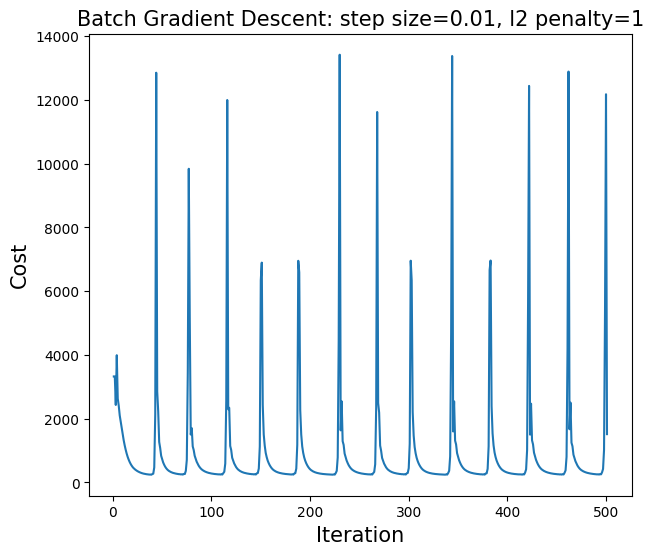

In [360]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,501,501),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Batch Gradient Descent: step size=0.01, l2 penalty=1', fontsize=15)
# plt.savefig('Q3.2 0011.png',dpi=300)

This has some strage oscillations. Let's not go with that. 

In [361]:
w_final, cost = bgd(x_train, y_train, 0.01, 0.1, 500)

Text(0.5, 1.0, 'Batch Gradient Descent: step size=0.01, l2 penalty=0.1')

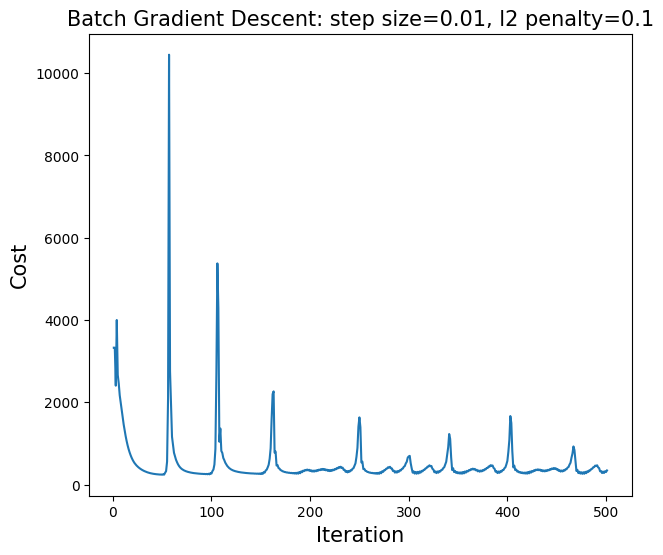

In [362]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,501,501),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Batch Gradient Descent: step size=0.01, l2 penalty=0.1', fontsize=15)
# plt.savefig('Q3.2 00101.png',dpi=300)

Still has oscillations, but not as bad. Let's test some other lambdas

In [363]:
w_final, cost = bgd(x_train, y_train, 0.01, 0.01, 500)

Text(0.5, 1.0, 'Batch Gradient Descent: step size=0.01, l2 penalty=0.01')

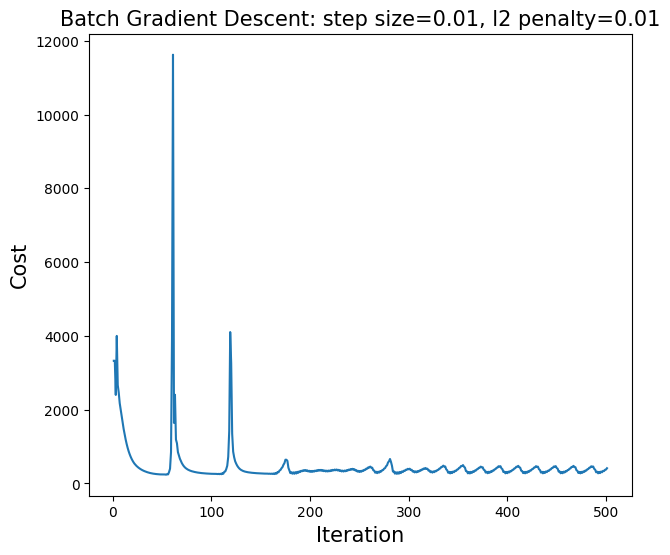

In [364]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,501,501),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Batch Gradient Descent: step size=0.01, l2 penalty=0.01', fontsize=15)
# plt.savefig('Q3.2 001001.png',dpi=300)

Maybe we can get rid of the oscillations by decreasing the step size

In [365]:
w_final, cost = bgd(x_train, y_train, 0.001, 0.01, 500)

Text(0.5, 1.0, 'Batch Gradient Descent: step size=0.001, l2 penalty=0.01')

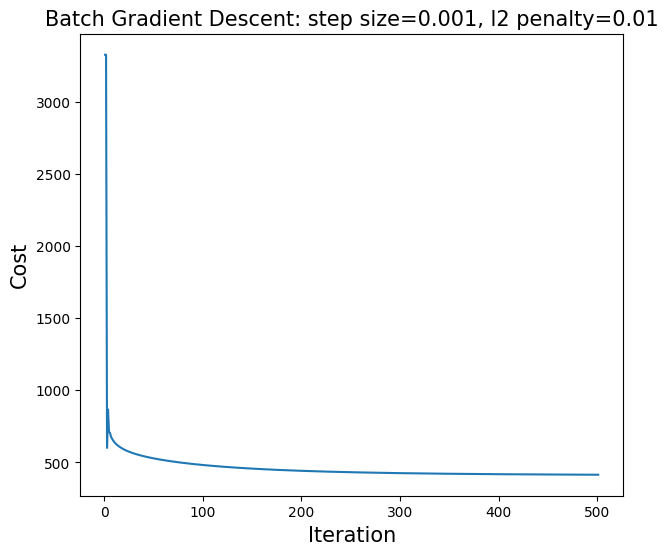

In [366]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,501,501),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Batch Gradient Descent: step size=0.001, l2 penalty=0.01', fontsize=15)
# plt.savefig('Q3.2 0001001.png',dpi=300)

# Q3.3

In [22]:
import random

In [215]:
#update function for stochastic gradient descent with l2 penalty
def sgd_update(data, labels, weight, step, penalty):
    
    #creat the w' vector for the update and calculating the cost
    w_p = np.append(weight[:-1],0)
    
    return weight+step*((labels -logistic_fn(data,weight))*data - penalty*w_p)

In [242]:
#calculates the cost of the logistic regression cost function with l2 penalty
def sgd_cost(data, labels, weights, penalty):
    
    s_vals = logistic_fn(data,weights)
    
    log_s = [log(x+1e-10) for x in s_vals]
    
    log_s_comp = [log((1-x)+1e-10) for x in s_vals]
    
    return -np.dot(labels,log_s)-np.dot((1-labels),log_s_comp)+penalty*np.linalg.norm(weights)

In [300]:
# Performs stochastic gradient descent
def sgd(data, labels, step, penalty, epochs, batch_size):
    
    data = add_fic(data)
    
    # Initialize the weight with the zero vector
    weight = np.zeros(data.shape[1])
    
    # Initialize the cost with the first weight vector of all zeros
    cost = [sgd_cost(data, labels, weight, penalty)]
    
    random.seed(42)
    
    for epoch in range(epochs):
        
        rstate = random.randint(0,data.shape[0])
        
        # Shuffle the data and labels for the epoch
        x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.75, random_state=rstate)
        
        for i in range(0, x_train.shape[0], batch_size):
            
            # Select the mini-batch of data and labels
            x = x_train[i:i+batch_size]
        
            y = y_train[i:i+batch_size]
            
            # Compute the logistic function and update the weight
            weight = sgd_update(x[0], y, weight, step, penalty)

            
            # Compute the cost for the mini-batch and store it
            cost += [sgd_cost(data, labels, weight, penalty)]
            
        
    return weight, cost

In [303]:
weight, cost = sgd(x, labels, step=0.00001, penalty=0.01, epochs=1, batch_size=1)

Text(0.5, 1.0, 'Stochastic Gradient Descent: step size=0.00001, l2 penalty=0.01')

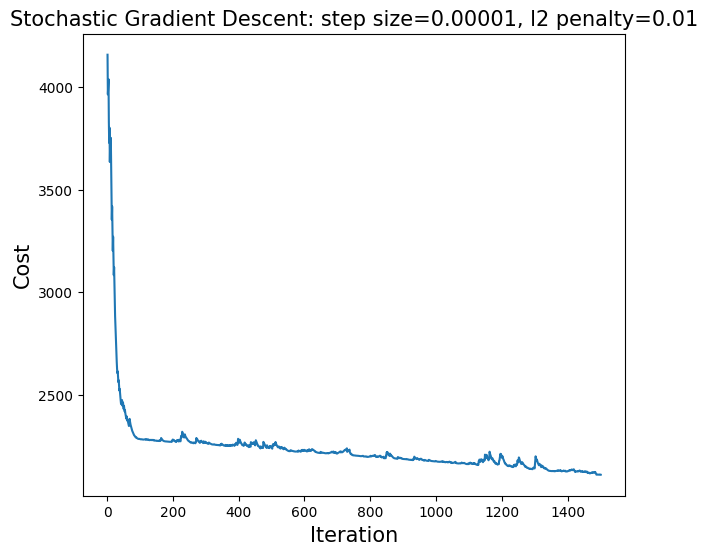

In [304]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,len(cost),len(cost)),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Stochastic Gradient Descent: step size=0.00001, l2 penalty=0.01', fontsize=15)
# plt.savefig('Q3.4 SGD.png',dpi=300)

# Q3.5

In [322]:
# Performs stochastic gradient descent
def sgd_step(data, labels, delta, penalty, epochs, batch_size):
    
    data = add_fic(data)
    
    # Initialize the weight with the zero vector
    weight = np.zeros(data.shape[1])
    
    # Initialize the cost with the first weight vector of all zeros
    cost = [sgd_cost(data, labels, weight, penalty)]
    
    random.seed(42)
    
    for epoch in range(epochs):
        
        rstate = random.randint(0,data.shape[0])
        
        # Shuffle the data and labels for the epoch
        x_train, x_val, y_train, y_val = train_test_split(data,labels, test_size = 0.75, random_state=rstate)
        
        for i in range(0, x_train.shape[0], batch_size):
            
            # Select the mini-batch of data and labels
            x = x_train[i:i+batch_size]
        
            y = y_train[i:i+batch_size]
            
            # Compute the logistic function and update the weight
            weight = sgd_update(x[0], y, weight, delta/(i+1), penalty)

            
            # Compute the cost for the mini-batch and store it
            cost += [sgd_cost(data, labels, weight, penalty)]
            
        
    return weight, cost

In [331]:
weight, cost = sgd_step(x, labels, delta=0.0001, penalty=0.01, epochs=1, batch_size=1)

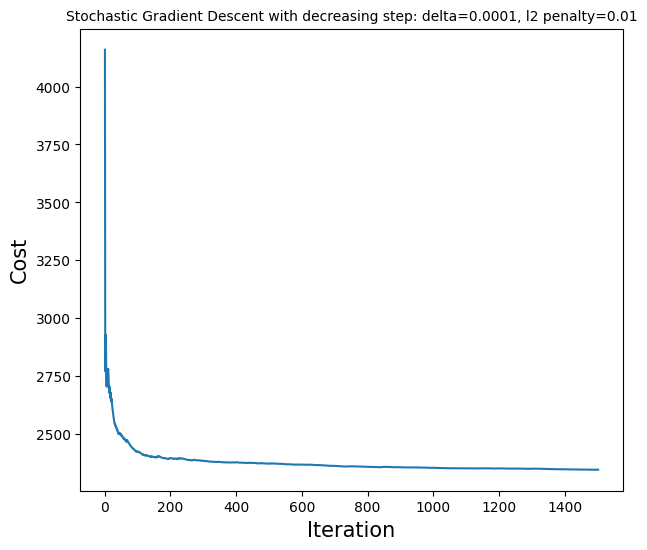

In [336]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,len(cost),len(cost)),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Stochastic Gradient Descent with decreasing step: delta=0.0001, l2 penalty=0.01', fontsize=10)
plt.savefig('Q3.5 SGD.png',dpi=300)

# Q3.6 

In [369]:
#normalize the data
fit = get_fit(x)
x_train = transform(x,fit)
x_train = add_fic(x_train) #add column of 1s for the bias

In [370]:
w_final, cost = bgd(x_train, labels, 0.001, 0.01, 500)

Text(0.5, 1.0, 'Batch Gradient Descent on all training: step size=0.01, l2 penalty=1')

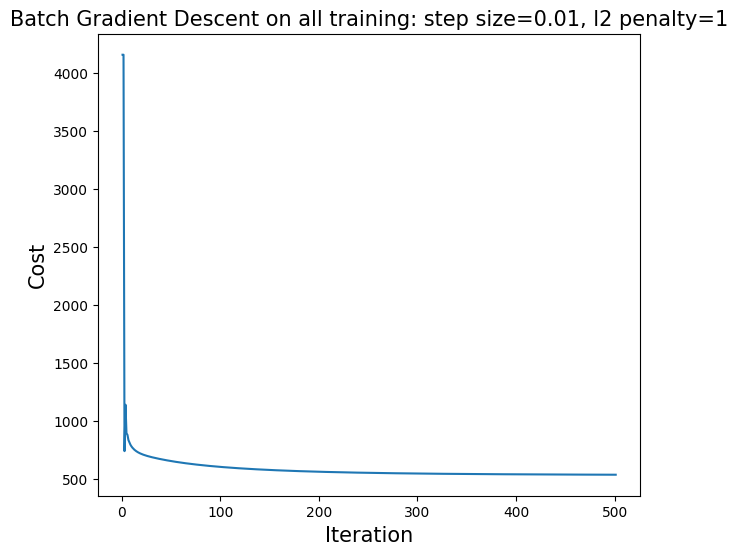

In [371]:
plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,len(cost),len(cost)),cost)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.title('Batch Gradient Descent on all training: step size=0.01, l2 penalty=1', fontsize=15)
# plt.savefig('Q3.2 0011.png',dpi=300)

In [375]:
#normalize the test data
x_test = transform(test,fit)
x_test = add_fic(x_test) #add column of 1s for the bias

In [376]:
y_pred = predict(x_test, w_final)

In [377]:
y_pred

array([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,

In [378]:
df = pd.DataFrame({'Id': np.linspace(1,len(y_pred),len(y_pred),dtype=int), 'Category': y_pred},dtype=np.int64)
df.to_csv('wine_preds.csv',index=False)

# Q5.1

In [395]:
def grid_gen(xlim,ylim, num):
    
    # Define the range of x and y values
    x_min, x_max = -xlim, xlim
    y_min, y_max = -ylim, ylim
    num_points = num  # number of points in each direction

    # Create a 1D array of x values and y values
    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)

    # Create a 2D grid of points using the meshgrid function
    X, Y = np.meshgrid(x, y)
    
    return X,Y

In [398]:
def f_eval(X,Y,p):
    
    return (np.abs(X)**p + np.abs(Y)**p)**(1/p)

In [408]:
def contour(p,xlim=None,ylim=None,num=None,f=None,grid=None,flag=True):
    
    if flag==True:
        X,Y = grid_gen(xlim,ylim,num)
        norm = f_eval(X,Y,p)
        
    else:
        norm=f
        
    fig = plt.figure(figsize=(10,10))
    cs = plt.contour(X,Y,norm)
    plt.clabel(cs,inline_spacing=5, fontsize=7)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Contour plot for l_{} norm'.format(p))
    plt.savefig('l_{}_norm_plot.png'.format(p), dpi=300)

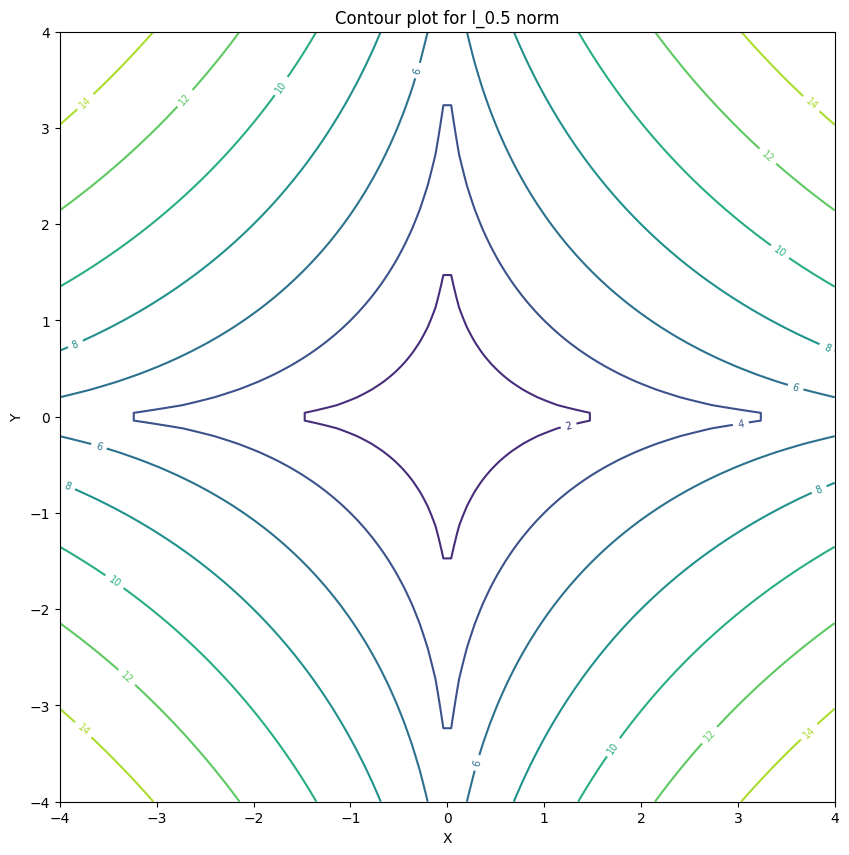

In [410]:
contour(0.5,4,4,100)

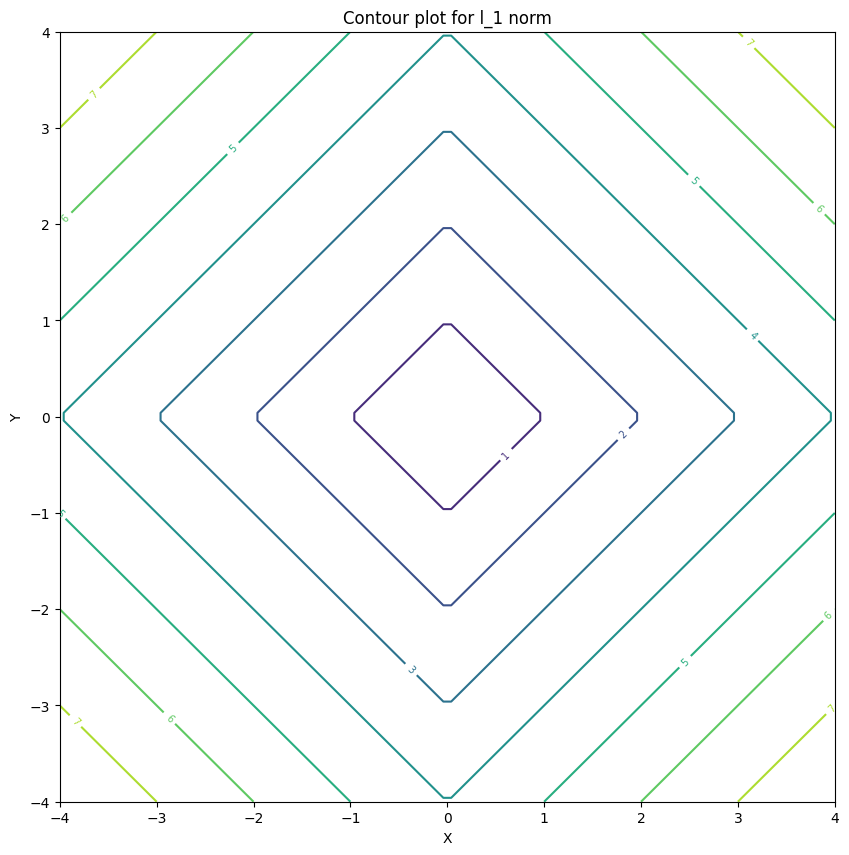

In [411]:
contour(1,4,4,100)

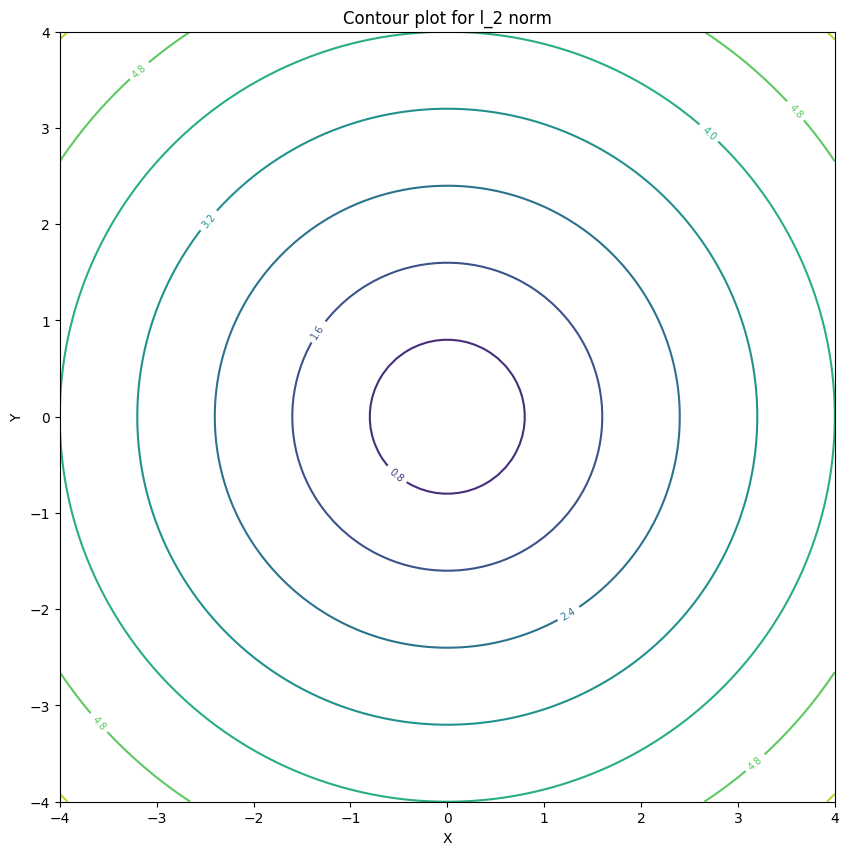

In [412]:
contour(2,4,4,100)

In [413]:
import sys

print("Python version:", sys.version)

Python version: 3.7.15 (default, Nov 24 2022, 18:44:54) [MSC v.1916 64 bit (AMD64)]


In [414]:
print("NumPy version:", np.__version__)

NumPy version: 1.21.5


In [416]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.0.2
